# Setup & Knowledge Graph Creation

In [ ]:
%%capture

import os
import pickle
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from stellargraph.data import UniformRandomMetaPathWalk

%matplotlib inline

SEED = 0

In [2]:
df = pd.read_csv('store/IMDB-Movie-Data.csv')
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [3]:
nodes = {'actor': [], 'movie': [], 'genre': [], 'director': [], 'year': []}

triples = []
for idx, row in df.iterrows():
    movie_title = row['Title']
    genres = list(map(lambda x: x.strip(), row['Genre'].split(",")))
    director = row['Director']
    actors = list(map(lambda x: x.strip(), row['Actors'].split(",")))
    year = row['Year']
    
    nodes['movie'].append(movie_title)
    nodes['actor'].extend(actors)
    nodes['director'].append(director)
    nodes['genre'].extend(genres)
    nodes['year'].append(year)
    
    for genre in genres:
        triples.append([movie_title, "of genre", genre])
        triples.append([genre, "genre of movie", movie_title])
    triples.append([director, "directed", movie_title])
    triples.append([movie_title, "directed by", director])
    for actor in actors:
        triples.append([movie_title, "had actor", actor.strip()])
        triples.append([actor.strip(), "acted in", movie_title])
    triples.append([year, "saw release of", movie_title])
    triples.append([movie_title, "released in", year])

In [4]:
triples[:8] + triples[-8:]

[['Guardians of the Galaxy', 'of genre', 'Action'],
 ['Action', 'genre of movie', 'Guardians of the Galaxy'],
 ['Guardians of the Galaxy', 'of genre', 'Adventure'],
 ['Adventure', 'genre of movie', 'Guardians of the Galaxy'],
 ['Guardians of the Galaxy', 'of genre', 'Sci-Fi'],
 ['Sci-Fi', 'genre of movie', 'Guardians of the Galaxy'],
 ['James Gunn', 'directed', 'Guardians of the Galaxy'],
 ['Guardians of the Galaxy', 'directed by', 'James Gunn'],
 ['Nine Lives', 'had actor', 'Jennifer Garner'],
 ['Jennifer Garner', 'acted in', 'Nine Lives'],
 ['Nine Lives', 'had actor', 'Robbie Amell'],
 ['Robbie Amell', 'acted in', 'Nine Lives'],
 ['Nine Lives', 'had actor', 'Cheryl Hines'],
 ['Cheryl Hines', 'acted in', 'Nine Lives'],
 [2016, 'saw release of', 'Nine Lives'],
 ['Nine Lives', 'released in', 2016]]

In [5]:
knowledge_graph = nx.DiGraph()

for key in nodes:
    for node in set(nodes[key]):
        knowledge_graph.add_node(node, label=key)

knowledge_graph.add_edges_from(
    (from_node, to_node, {'relation': relation}) 
    for from_node, relation, to_node in triples
)

pickle.dump(knowledge_graph, open("store/imdb.kg", 'wb'))

num_nodes = len(knowledge_graph.nodes())
print(num_nodes)

3623


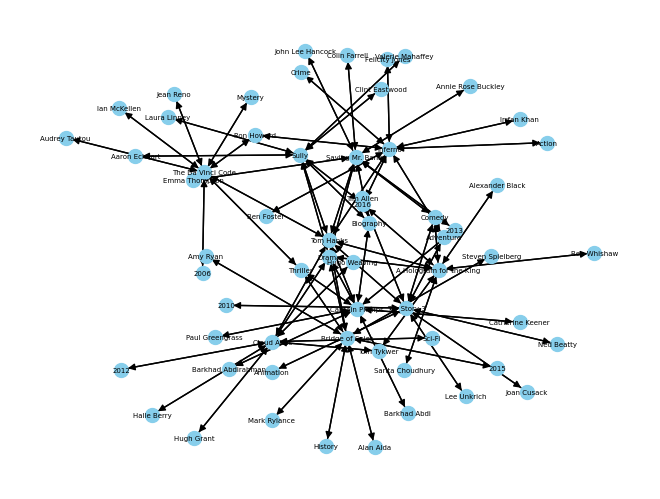

In [6]:
arbitrary_nodes = nx.ego_graph(knowledge_graph, "Tom Hanks", radius=2).nodes()
subgraph = knowledge_graph.subgraph(arbitrary_nodes)
pos = nx.spring_layout(subgraph, k=0.5)
nx.draw(subgraph, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=5)
plt.show()

# Creating node embeddings using MetaPath2Vec

Most of the code for this segment was taken from the MetaPath2Vec tutorial present [here](https://stellargraph.readthedocs.io/en/stable/demos/embeddings/metapath2vec-embeddings.html).

In [7]:
from stellargraph import StellarDiGraph
from stellargraph.data import UniformRandomMetaPathWalk

walk_length = 10
num_walks = 10

non_movie_types = ["actor", "director", "year", "genre"]
metapaths = []
for type_1 in non_movie_types:
    for type_2 in non_movie_types:
        metapath = [type_1, "movie", type_2, "movie", type_1]
        metapaths.append(metapath)
        metapath = ["movie", type_1, "movie", type_2, "movie"]
        metapaths.append(metapath)

stellar_graph = StellarDiGraph.from_networkx(knowledge_graph)
random_walker = UniformRandomMetaPathWalk(stellar_graph)

walks_loc = "store/walks.pkl"
if os.path.exists(walks_loc):
    walks = pickle.load(open(walks_loc, 'rb'))
else:
    walks = random_walker.run(
        nodes=list(stellar_graph.nodes()),
        length=walk_length,
        n=num_walks,
        metapaths=metapaths,
        seed=0
    )
    pickle.dump(walks, open(walks_loc, 'wb'))

print(f"Number of random walks: {len(walks)}")

Number of random walks: 264800


In [8]:
walks[0]

['Winona Ryder',
 'Black Swan',
 'Natalie Portman',
 'Your Highness',
 'Danny McBride',
 'Pineapple Express',
 'Gary Cole',
 'Pineapple Express',
 'Danny McBride',
 'Angry Birds']

In [9]:
from gensim.models import Word2Vec

word2vec_loc = "store/word2vec.model"
if os.path.exists(word2vec_loc):
    model = pickle.load(open(word2vec_loc, 'rb'))
else:
    model = Word2Vec(walks, vector_size=128, window=5, min_count=0, sg=1, workers=8, seed=0)
    pickle.dump(model, open(word2vec_loc, 'wb'))

### Visualizing the embeddings

In [ ]:
node_ids = model.wv.index_to_key
node_embeddings = (model.wv.vectors)
node_targets = [stellar_graph.node_type(node_id) for node_id in node_ids]

trans = TSNE(n_components=2, random_state = SEED)
node_embeddings_2d = trans.fit_transform(node_embeddings)
print(node_embeddings_2d.shape)

/raid/infolab/vaibhavraj/install/miniconda3/envs/cs635/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/raid/infolab/vaibhavraj/install/miniconda3/envs/cs635/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colours, alpha=0.3)
plt.title("TSNE visualization of node embeddings")
plt.show()